In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def trata_producto_names(df_producto):
    from nltk.stem.snowball import SnowballStemmer

    df_producto['short_names'] = df_producto.NombreProducto.str.extract('^(\D*)')
    df_producto['short_names_processed'] = df_producto['short_names'].map(lambda x: " ".join([i for i in x.lower().split() if i not in stopwords.words('spanish')]))

    stemmer = SnowballStemmer("spanish")

    df_producto['short_names_processed'] = (df_producto['short_names_processed']
                                            .map(lambda x: " ".join([stemmer.stem(i) for i in x.lower().split()])))
    df_aux_producto = df_producto['short_names_processed'].value_counts()[df_producto['short_names_processed'].value_counts() > 10].reset_index()

    df_producto['flavor_choc'] = df_producto.short_names_processed.str.contains('choc') * 1
    df_producto['flavor_vainill'] = df_producto.short_names_processed.str.contains('vainill') * 1
    df_producto['flavor_canel'] = df_producto.short_names_processed.str.contains('canel') * 1

    df_producto['NombreProducto'] = df_producto['NombreProducto'].str.upper()
    df_producto['NombreProducto'] = df_producto.apply(lambda x :x['NombreProducto'].replace(str(x['Producto_ID']),'').strip(), axis=1 )
    df_producto = pd.DataFrame(df_producto.loc[1:])
    df_producto['fabricante'] = df_producto.NombreProducto.str.split(' ').str[-1]
    df_producto.ix[df_producto.fabricante == '1KG','fabricante'] = ''
    df_producto['NombreProducto'] = df_producto.apply(lambda x :x['NombreProducto'].replace(x['fabricante'],'').strip(), axis=1 )

    reg = '(\d{1,4}G|\d{1,4}KG|\d{1,4}ML|\d{1,4}\ ML)'
    df_producto['volume'] = df_producto.NombreProducto.str.extract(reg)

    df_producto['NombreProducto'] = df_producto.apply(lambda x :x['NombreProducto'].replace(str(x['volume']),'').replace('  ',' ').strip(), axis=1 )

    reg = '(\d{1,5}P)'
    df_producto['unidade'] = df_producto.NombreProducto.str.extract(reg)
    df_producto['NombreProducto'] = df_producto.NombreProducto.str.replace(reg, '').str.replace('  ',' ').str.strip()

    aux = pd.DataFrame({'Producto_ID':[0],'NombreProducto':['NO IDENTIFICADO']})
    df_producto = df_producto.append(aux)

    df_producto['unidade'] = df_producto.volume.str.extract('([A-Z])')
    df_producto['volume'] = df_producto.volume.str.replace('([A-Z])','')
    df_producto['product_name_length'] = df_producto.NombreProducto.str.split(' ').str.len()
    return df_producto

In [3]:
def count_cliente_by_route():
    l = []
    for i in range(3,10):
        df_week = pd.read_csv('input/train_week%s.csv' % i, usecols=['Cliente_ID','Ruta_SAK'])
        count_cliente = df_week.merge(df_cliente, on='Cliente_ID', how='left')
        count_cliente.ix[(count_cliente.NombreCliente != 'SIN NOMBRE'), 'NombreCliente'] = 'NO IDENTIFICADO'
        count_cliente = df_week.merge(df_cliente, on='Cliente_ID', how='left')
        count_cliente.ix[(count_cliente.NombreCliente != 'SIN NOMBRE'), 'NombreCliente'] = 'NO IDENTIFICADO'
        count_cliente = count_cliente[['Ruta_SAK','NombreCliente']].groupby(['Ruta_SAK']).count().reset_index()
        l.append(count_cliente)
    result = pd.concat(l)
    result = result.groupby('Ruta_SAK').mean().reset_index()
    result.columns = ['Ruta_SAK','count_clientes']
    return result

In [4]:
def process_venta_producto():
    l = []
    print('week: ')
    for week in range(3,10):
        print(week, end='\r')
        df_week = pd.read_csv('input/train_week%s.csv' % week, usecols=['Producto_ID','Venta_hoy'])
        prod_venta = df_week[['Producto_ID','Venta_hoy']].groupby('Producto_ID').median().reset_index()
        l.append(prod_venta)
    df_venta = pd.concat(l)
    df_venta = df_venta.groupby('Producto_ID').median().reset_index()
    df_venta['Venta_hoy_log10'] = np.round(np.log10(df_venta['Venta_hoy'].values + 1))
    return df_venta

In [5]:
def process_venta_agencia(df_townstate):
    l = []
    print('week: ')
    for week in range(3,10):
        print(week, end='\r')
        df_week = pd.read_csv('input/train_week%s.csv' % week, usecols=['Agencia_ID','Venta_hoy'])
        aux = df_week.merge(df_townstate, how='left', on='Agencia_ID')
        prod_venta = aux.groupby('State').median().reset_index()
        l.append(prod_venta)
    df_venta = pd.concat(l)
    df_venta = df_venta[['Agencia_ID','Venta_hoy','State']].groupby('State').median().reset_index()
    df_venta['Venta_hoy_log10'] = np.round(np.log(df_venta['Venta_hoy'].values+1))
    return df_venta

In [6]:
def process_producto():
    df_producto = pd.read_csv('input/producto_tabla.csv.gz', compression='gzip')
    df_producto = trata_producto_names(df_producto)
    return df_producto

In [435]:
def process_df(df, test=False):    
    if not test:
#         df = df.drop(['Venta_uni_hoy','Venta_hoy','Dev_uni_proxima'], axis=1)
        df = df.ix[df.Demanda_uni_equil<20]   
    
    
    
    
    
    df = df.merge(df_agencia_canal, on='Canal_ID', how='left')
    df = df.merge(df_agencia_produto, on='Agencia_ID', how='left')
    df = df.merge(df_cliente_canal, on='Canal_ID', how='left')
    
    
    df = df.merge(df_media_unidades, on=['Cliente_ID','Producto_ID'], how='left')
    df = df.merge(df_media_clientes_depot, on='Agencia_ID', how='left')
    df = df.merge(df_popularidade_produto, on='Producto_ID', how='left')
    df = df.merge(df_produto_preco_medio, on='Producto_ID', how='left')
    df = df.merge(df_clientes_ruta, on='Ruta_SAK', how='left')
        
    df = df.merge(df_producto[['flavor_choc', 'flavor_vainill', 'flavor_canel','volume', 'fabricante','Producto_ID', 'product_name_length']], how='left',on='Producto_ID')
    df = df.merge(df_townstate[['Agencia_ID','ag','bimbo']], on='Agencia_ID', how='left')
    
    df.volume = df.volume.fillna(-9999).astype('int')

    df.ix[df.volume>500,'volume'] = 9999
        
    
    df['Canal_ID'] = (df['Canal_ID'] == 1) *1
        
    return df

In [352]:
def compras_cliente_mean():
    l = []
    for i in range(3,10):
        df = pd.read_csv('input/train_week%i.csv' % (i), usecols=['Cliente_ID','Producto_ID','Venta_uni_hoy'])
        l.append(df.groupby(['Cliente_ID','Producto_ID']).mean().reset_index())
    df = pd.concat(l)
    df = df.groupby(['Cliente_ID','Producto_ID']).mean().reset_index()
    df.columns = ['Cliente_ID','Producto_ID','media_de_unidades']
    df['media_de_unidades_log'] = np.log(df['media_de_unidades'].values+1)
    df['media_de_unidades_sqrt'] = np.sqrt(df['media_de_unidades'].values)    
    return df

In [353]:
# def mean_clientes_depot():
#     l = []
#     for i in range(3,10):
#         df = pd.read_csv('input/train_week%i.csv' % (i), usecols=['Agencia_ID','Cliente_ID'])
#         l.append(df.groupby(['Agencia_ID']).count().reset_index())
#     df = pd.concat(l)
#     df = df.groupby(['Agencia_ID']).mean().reset_index()
#     df.columns = ['Agencia_ID','media_de_clientes_depot']
#     df['media_de_clientes_depot_log'] = np.log(df['media_de_clientes_depot'].values+1)
#     df['media_de_clientes_depot_sqrt'] = np.sqrt(df['media_de_clientes_depot'].values)
#     return df

In [354]:
def produto_popularidade():
    l = []
    for i in range(3,10):
        df = pd.read_csv('input/train_week%i.csv' % (i), usecols=['Producto_ID','Venta_uni_hoy'])
        l.append(df.groupby(['Producto_ID']).sum().reset_index())
    df = pd.concat(l)
    df = df.groupby(['Producto_ID']).mean().reset_index()
    df.columns = ['Producto_ID','produto_popularidade']
    df['produto_popularidade_log'] = np.log(df['produto_popularidade'].values+1)
    df['produto_popularidade_sqrt'] = np.sqrt(df['produto_popularidade'].values)
    return df

In [355]:
def produto_preco_mean():
    l = []
    for i in range(3,10):
        df = pd.read_csv('input/train_week%i.csv' % (i), usecols=['Producto_ID','Venta_uni_hoy','Venta_hoy'])
        df['preco_medio'] = df['Venta_hoy'] / df['Venta_uni_hoy']
        l.append(df.groupby(['Producto_ID']).mean().reset_index())
    df = pd.concat(l)
    df = df.groupby(['Producto_ID']).mean().reset_index()
    df[['Producto_ID','preco_medio']].columns = ['Producto_ID','preco_medio']
    df['preco_medio'] = df['preco_medio'].fillna(0)
    df['preco_medio_log'] = np.log(df['preco_medio'].values+1)
    df['preco_medio_sqrt'] = np.sqrt(df['preco_medio'].values)
    return df[['Producto_ID','preco_medio','preco_medio_log','preco_medio_sqrt']]

In [423]:
def count_clientes_ruta():
    l = []
    for i in range(3,10):
        df = pd.read_csv('input/train_week%i.csv' % (i), usecols=['Ruta_SAK','Cliente_ID'])
        df = df.ix[~df.duplicated()]
        l.append(df.groupby(['Ruta_SAK']).count().reset_index())
    df = pd.concat(l)
    df = df.groupby(['Ruta_SAK']).mean().reset_index()
    df.columns = ['Ruta_SAK','clientes_por_rota']
    df['clientes_por_rota_log'] = np.log(df['clientes_por_rota'].values+1)
    df['clientes_por_rota_sqrt'] = np.sqrt(df['clientes_por_rota'].values)
    return df

In [422]:
def count_clientes_canal():
    l = []
    for i in range(3,10):
        df = pd.read_csv('input/train_week%i.csv' % (i), usecols=['Canal_ID','Cliente_ID'])
        df = df.ix[~df.duplicated()]
        l.append(df.groupby(['Canal_ID']).count().reset_index())
    df = pd.concat(l)
    df = df.groupby(['Canal_ID']).mean().reset_index()
    df.columns = ['Canal_ID','clientes_por_canal']
    df['clientes_por_canal_log'] = np.log(df['clientes_por_canal'].values+1)
    df['clientes_por_canal_sqrt'] = np.sqrt(df['clientes_por_canal'].values)
    return df

In [426]:
def count_agencia_produto():
    l = []
    for i in range(3,10):
        df = pd.read_csv('input/train_week%i.csv' % (i), usecols=['Agencia_ID','Producto_ID'])
        df = df.ix[~df.duplicated()]
        l.append(df.groupby(['Agencia_ID']).count().reset_index())
    df = pd.concat(l)
    df = df.groupby(['Agencia_ID']).mean().reset_index()
    df.columns = ['Agencia_ID','agencia_por_produto']
    df['agencia_por_produto_log'] = np.log(df['agencia_por_produto'].values+1)
    df['agencia_por_produto_sqrt'] = np.sqrt(df['agencia_por_produto'].values)
    return df

In [428]:
def count_agencia_canal():
    l = []
    for i in range(3,10):
        df = pd.read_csv('input/train_week%i.csv' % (i), usecols=['Canal_ID','Agencia_ID'])
        df = df.ix[~df.duplicated()]
        l.append(df.groupby(['Canal_ID']).count().reset_index())
    df = pd.concat(l)
    df = df.groupby(['Canal_ID']).mean().reset_index()
    df.columns = ['Canal_ID','canal_por_agencia']
    df['canal_por_agencia_log'] = np.log(df['canal_por_agencia'].values+1)
    df['canal_por_agencia_sqrt'] = np.sqrt(df['canal_por_agencia'].values)
    return df

In [357]:
df_media_unidades = compras_cliente_mean()
# df_media_clientes_depot = mean_clientes_depot()
df_popularidade_produto = produto_popularidade()
df_produto_preco_medio = produto_preco_mean()
df_clientes_ruta = count_clientes_ruta()

In [424]:
df_cliente_canal = count_clientes_canal()

In [427]:
df_agencia_produto = count_agencia_produto()

In [429]:
df_agencia_canal = count_agencia_canal()

In [344]:
from nltk.corpus import stopwords

In [345]:
stop_words = stopwords.words('spanish')

In [346]:
df_townstate = pd.read_csv('input/town_state.csv.gz', compression='gzip')
df_townstate['bimbo'] = df_townstate.Town.str.contains('BIMBO') * 1
df_townstate['ag'] = df_townstate.Town.str.contains('AG.') * 1

In [283]:
pd.options.display.max_rows = 30

In [284]:
df_producto = process_producto()

In [285]:
# df_process['fabricante'].value_counts()

In [445]:
cols = [
# #     'media_de_clientes_depot_sqrt',
#     'media_de_unidades_sqrt',
#     'produto_popularidade_sqrt',
#     'preco_medio_sqrt',
#     'clientes_por_rota_sqrt',
    
    
#     'media_de_clientes_depot_log',
    'media_de_unidades_log',
    'produto_popularidade_log',
    'preco_medio_log',
    'clientes_por_rota_log',
    'canal_por_agencia_log',
#     'agencia_por_produto_log',
#     'clientes_por_canal_log',
# #     'media_de_clientes_depot',
#     'media_de_unidades',
#     'produto_popularidade',
#     'preco_medio',
#     'clientes_por_rota',
    
    
#     'volume',
    'Canal_ID',
#     'fabricante',
#     'ag',
#     'bimbo',
#     'product_name_length',
#     'flavor_choc',
#     'flavor_vainill',
#     'flavor_canel',
]

In [415]:
# aux.Agencia_ID.dtype 

In [416]:
# enc._n_values

# fiitting model

In [431]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

In [436]:
# rf = ExtraTreesRegressor(n_estimators=50, max_features=1.0,min_samples_split=3,n_jobs=4)



def train(x, y):
    results = []
    kf = StratifiedKFold(y, n_folds=10, random_state=401)
    for (train, test) in kf:
        rf.fit(x[train], y[train])
        y_pred = rf.predict(x[test])
        result = mean_squared_error(y[test], y_pred)
#         print(result)
        results.append(result)
        print(len(results), end='\r')
    return results
        

In [437]:
# df.columns

In [438]:
rf = RandomForestRegressor(random_state=401)

for week in range(3,9):
#     df_week = pd.read_csv('input/train_week%s.csv' % week, usecols=['Demanda_uni_equil','Cliente_ID','Agencia_ID','Producto_ID','Ruta_SAK','Canal_ID'])
    for df_week in pd.read_csv('input/train_week%s.csv' % week, 
                               usecols=['Demanda_uni_equil','Cliente_ID','Agencia_ID','Producto_ID','Ruta_SAK','Canal_ID'], chunksize=10000):
        aux = process_df(df_week)
        df = aux[cols+['Demanda_uni_equil']]
        df = pd.get_dummies(df)

        print('fitting week %s... ' % week,)
        print(' ')
        # for x in range(10000,df.shape[0]-10000,10000):
        df_partial = df
        x = df_partial.drop(['Demanda_uni_equil'], axis=1).values
        y = df_partial['Demanda_uni_equil'].values
        results = train(x,y)
        print('mean result: ',np.mean(results))
        break
    break

fitting week 3... 
 
mean result:  7.40400946872


In [238]:
# benchmark => 7.38

In [373]:
df_clientes = pd.read_csv('input/cliente_tabla.csv.gz')

In [379]:
df_clientes.columns

Index(['Cliente_ID', 'NombreCliente'], dtype='object')

In [ ]:
aux[cols].dtypes

In [ ]:
9.58

# testing feature importances

In [ ]:
df

In [439]:
a = df

In [440]:
rf.feature_importances_.shape

(10,)

In [441]:
# a.columns

In [442]:
a.columns[:]

Index(['media_de_unidades_log', 'produto_popularidade_log', 'preco_medio_log',
       'clientes_por_rota_log', 'canal_por_agencia_log',
       'agencia_por_produto_log', 'clientes_por_canal_log', 'volume',
       'Canal_ID', 'product_name_length', 'Demanda_uni_equil'],
      dtype='object')

<Container object of 10 artists>

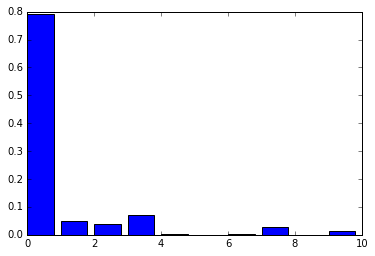

In [444]:
plt.bar(range(0,10), height=rf.feature_importances_)

In [ ]:
# aux.Demanda_uni_equil.value_counts().plot(kind='bar')

In [ ]:
aux.columns

In [ ]:
df_test = initial_week_processing(df_test)

In [ ]:
df_test = pd.read_csv('input/test.csv.gz', compression='gzip')

In [ ]:
df = process_df(df_test, test=True)
# df = aux.iloc[np.random.permutation(len(aux))]
df = pd.get_dummies(df)
res = rf.predict(df.values)

In [ ]:
a = df_test.merge(df_producto, how='left', on='Producto_ID')

In [ ]:
a.Venta_uni_hoy.hist(range=(0,10), bins=2)

In [ ]:
# df_process['short_names_processed']

In [ ]:
# pd.get_dummies(df_process[0:100][cols])

In [ ]:
f = plt.subplots()
i = 444
for v in x.T:
    i+=1
    f.hist(v)

In [ ]:
df.columns

In [ ]:
count_entregas(df, 'Agencia_ID')